## Intro

[Strava](http://strava.com/) is used by many endurance athletes to track their endurance sports. I log every run and ride I do in Strava. Using both [David Yang's awesome medium post](https://medium.com/@xdyang70/running-data-analysis-61ac6b08945c) and [Mark Koester's epic github repo qs_ledger](https://github.com/markwk/qs_ledger) as inspiration, I am going to download my 2019 strava cycling data using [stravalib](https://pythonhosted.org/stravalib/index.html), strava's API, and conduct an exploratory data analysis.

## Importing dependencies

In [1]:
import pandas as pd
import altair as alt
import numpy as np
from stravalib import unithelper
from vega_datasets import data

## Dowloading data from the Strava API using stravalib

In [2]:
from stravalib import Client
from conf.credentials import *

client_id = client_id
client_secret = client_secret
client = Client()
url = client.authorization_url(
    client_id=client_id,
    redirect_uri='http://localhost/'
)
print(url)

https://www.strava.com/oauth/authorize?client_id=24067&redirect_uri=http%3A%2F%2Flocalhost%2F&approval_prompt=auto&response_type=code&scope=read%2Cactivity%3Aread


In [3]:
code = '3a07ac8420f8cbc5d107c120e838e5e33c132a6c' # Change t8f32b9be13bbc477e6cda663fb34ebcea302a99dhis to what you see
access_token = client.exchange_code_for_token(
    client_id=client_id,
    client_secret=client_secret,
    code=code
)
refresh_token = access_token['access_token']
client = Client(access_token=refresh_token)
# Test the connection
athlete = client.get_athlete()
print(f'Hello, {athlete.firstname}, I know you.')

Hello, Chase, I know you.


In [4]:
rides = pd.DataFrame(
    columns=[
        'date',
        'moving_time',
        'activity_id',
        'name',
        'distance',
        'elevation gain',
        'type',
        'trainer',
        'average_speed',
        'average_watts',
        'suffer_score',
        'average_heartrate',
        'average_cadence',
        'kilojoules',
        'gear_id',
        'average_temp',
        'start_longitude',
        'start_latitude'
    ]
)
for activity in client.get_activities(
    after="2018-12-31T00:00:00Z",
    before="2020-01-01T00:00:00Z"):
    if activity.type == "Ride":
        rides = rides.append(
            {
                'date': activity.start_date_local.date(),
                'activity_id': activity.id, 
                'moving_time': activity.moving_time,
                'name': activity.name, 
                'distance': round(float(unithelper.miles(activity.distance)), 2),
                'elevation gain': float(unithelper.feet(activity.total_elevation_gain)),
                'type': activity.type,
                'trainer': activity.trainer,
                'average_speed': float(unithelper.miles_per_hour(activity.average_speed)),
                'average_watts': activity.average_watts,
                'suffer_score': activity.suffer_score,
                'average_heartrate': activity.average_heartrate,
                'average_cadence': activity.average_cadence,
                'kilojoules': activity.kilojoules,
                'gear_id': activity.gear_id,
                'average_temp': activity.average_temp,
                'start_longitude': activity.start_longitude,
                'start_latitude': activity.start_latitude
            }, 
            ignore_index=True
        )

In [5]:
rides.head()

,date,moving_time,activity_id,name,distance,elevation gain,type,trainer,average_speed,average_watts,suffer_score,average_heartrate,average_cadence,kilojoules,gear_id,average_temp,start_longitude,start_latitude
0,2019-12-31,00:20:03,2971700880,FTP Test,7.48,0.000000,Ride,True,22.385021,225.5,55,172.5,94.1,271.3,b5499491,None,None,None
1,2019-12-31,00:09:58,2971670149,10 min FTP Warm Up Ride with Matt Wilpers,2.98,0.000000,Ride,True,17.940229,132.9,7,141.4,91.6,79.4,b4933861,None,None,None
2,2019-12-29,00:22:59,2966736434,Coronado Island Perkins Ride part 2,3.34,26.902887,Ride,False,8.706156,55.3,5,123,None,76.2,b1315248,None,-117.18,32.68
3,2019-12-29,00:51:56,2966569823,Coronado Island Perkins Ride part 1,8.29,38.713911,Ride,False,9.571850,63.7,13,122.5,None,198.6,b1315248,None,-117.17,32.7
4,2019-12-24,00:20:14,2954036814,20 min 16 sec Just Ride,6.03,0.000000,Ride,True,17.882069,129,13,139.4,86,156.6,b5499491,None,None,None


## Data Pre-Processing

In [6]:
rides['date'] = pd.to_datetime(rides['date'])
#rides['moving_time'] = pd.to_datetime(rides['moving_time'])
#rides['moving_time'] = rides['moving_time'].dt.minutes
rides['moving_time'] = rides['moving_time'].apply(lambda x: x/np.timedelta64(1,'m'))

# date additions of time_added
rides['year'] = rides['date'].dt.year
rides['month'] = rides['date'].dt.month
rides['mnth_yr'] = rides['date'].apply(lambda x: x.strftime('%Y-%m')) # note: not very efficient
rides['day'] = rides['date'].dt.day
rides['dow'] = rides['date'].dt.weekday_name
rides['week_number'] = rides['date'].dt.week
rides['hour'] = rides['date'].dt.hour
rides['date'] = rides['date'].apply(lambda x: x.strftime('%Y-%m-%d')) # note: not very efficient

In [7]:
rides.head()

,date,moving_time,activity_id,name,distance,elevation gain,type,trainer,average_speed,average_watts,...,average_temp,start_longitude,start_latitude,year,month,mnth_yr,day,dow,week_number,hour
0,2019-12-31,20.050000,2971700880,FTP Test,7.48,0.000000,Ride,True,22.385021,225.5,...,None,None,None,2019,12,2019-12,31,Tuesday,1,0
1,2019-12-31,9.966667,2971670149,10 min FTP Warm Up Ride with Matt Wilpers,2.98,0.000000,Ride,True,17.940229,132.9,...,None,None,None,2019,12,2019-12,31,Tuesday,1,0
2,2019-12-29,22.983333,2966736434,Coronado Island Perkins Ride part 2,3.34,26.902887,Ride,False,8.706156,55.3,...,None,-117.18,32.68,2019,12,2019-12,29,Sunday,52,0
3,2019-12-29,51.933333,2966569823,Coronado Island Perkins Ride part 1,8.29,38.713911,Ride,False,9.571850,63.7,...,None,-117.17,32.7,2019,12,2019-12,29,Sunday,52,0
4,2019-12-24,20.233333,2954036814,20 min 16 sec Just Ride,6.03,0.000000,Ride,True,17.882069,129,...,None,None,None,2019,12,2019-12,24,Tuesday,52,0


## Exploratory Data Analysis

In [8]:
# Generate Range of Dates from First Run added to Today
first_date = rides['date'].tail(1).values[0]
last_date = rides['date'].head(1).values[0]
all_dates = pd.date_range(start=first_date, end=last_date)
all_dates = pd.DataFrame(all_dates, columns=['date'])

In [9]:
# Total Activites / Days
perc_activities = round(len(rides) / len(all_dates), 2)
perc_activities

0.43

In [10]:
rides['date'] = pd.to_datetime(rides['date'])

cycling_distance_per_date = pd.merge(left=all_dates, right=rides, left_on="date", right_on="date", how="outer")
cycling_distance_per_date['distance'].fillna(0, inplace=True)

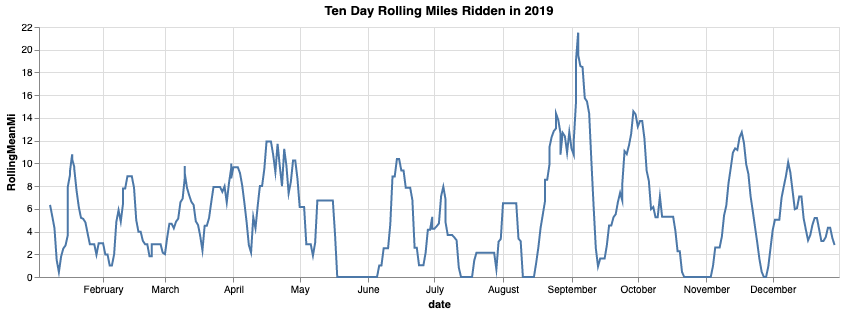

In [11]:
cycling_distance_per_date['RollingMeanMi'] = cycling_distance_per_date['distance'].rolling(window=10, center=True).mean()

chart = alt.Chart(cycling_distance_per_date).mark_line().encode(
    x='date',
    y='RollingMeanMi:Q'
)
chart.properties(
    width=800,
    height=250,
    title='Ten Day Rolling Miles Ridden in 2019'
)


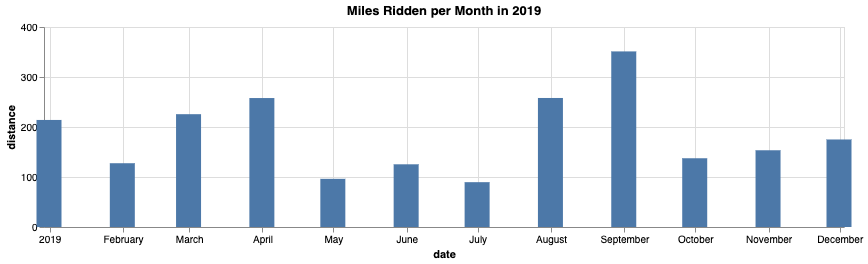

In [12]:
cycling_month = rides.groupby(['mnth_yr'])['distance'].sum().reset_index(name='distance')

alt.Chart(cycling_month).mark_bar(size=25).encode(
    x=alt.X('mnth_yr:T', axis=alt.Axis(title='date')),
    y='distance:Q'
).properties(
    width=800,
    height=200,
    title='Miles Ridden per Month in 2019'
)

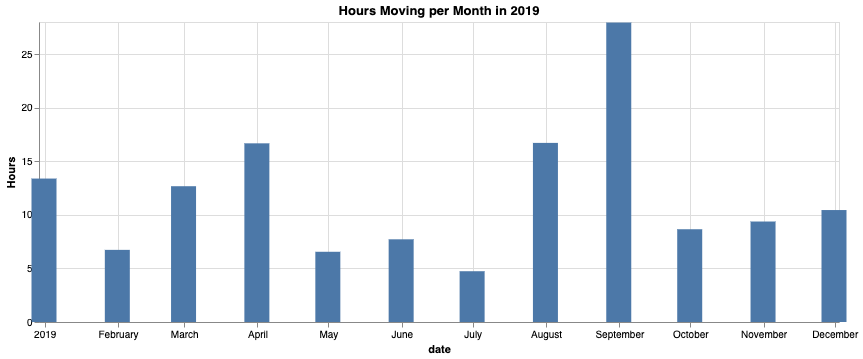

In [13]:
cycling_month_time = rides.groupby(['mnth_yr'])['moving_time'].sum().reset_index(name='moving_time')
cycling_month_time['hours'] = cycling_month_time['moving_time'] / 60

alt.Chart(cycling_month_time).mark_bar(size=25).encode(
    x=alt.X('mnth_yr:T', axis=alt.Axis(title='date')),
    y=alt.Y('hours:Q', axis=alt.Axis(title='Hours'))
).properties(
    width=800,
    title='Hours Moving per Month in 2019'
)

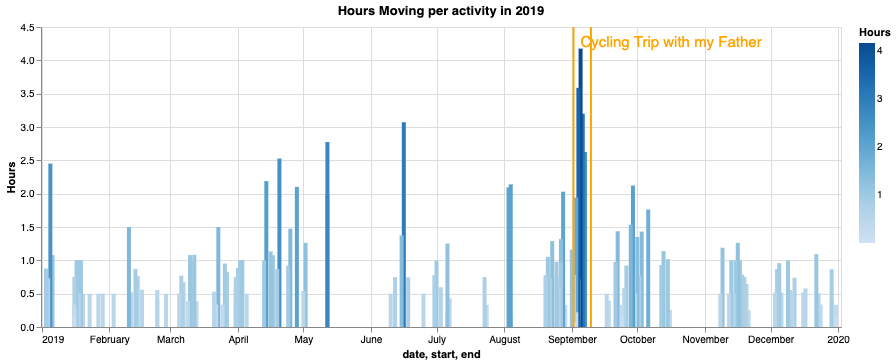

In [14]:
rides['Hours'] = rides['moving_time'] / 60

bars = alt.Chart(rides).mark_bar(size=4).encode(
    x="date:T",
    y="Hours:Q",
    color='Hours:Q'
).properties(
    width=800,
    title='Hours Moving per activity in 2019'
)
events = pd.DataFrame([
    {
        "start": "2019-09-02",
        "end": "2019-09-10",
        "event": "Cycling Trip with my Father"
    }
])

end = alt.Chart(events).mark_rule(
    color="#FFA500",
    strokeWidth=2
).encode(
    x='end:T'
).transform_filter(alt.datum.event == "Cycling Trip with my Father")


start = alt.Chart(events).mark_rule(
    color="#FFA500",
    strokeWidth=2
).encode(
    x='start:T'
).transform_filter(alt.datum.event == "Cycling Trip with my Father")


text = alt.Chart(events).mark_text(
    align='left',
    baseline='middle',
    dx=7,
    dy=-135,
    size=15
).encode(
    x='start:T',
    x2='end:T',
    text='event',
    color=alt.value('#FFA500 ')
)

(bars + text+ start + end).properties(width=600)

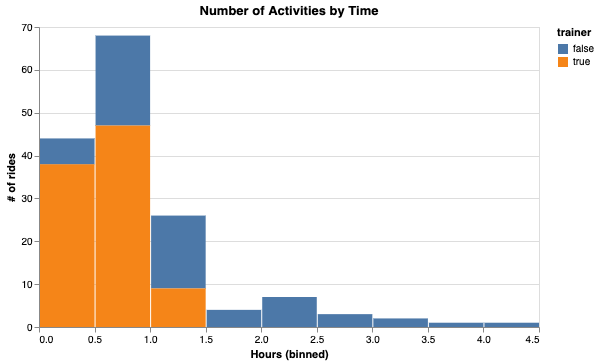

In [15]:
alt.Chart(rides).mark_bar().encode(
    alt.X("Hours:Q", bin=True),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
    color='trainer:N',
).properties(
    width=500,
    title='Number of Activities by Time'
)

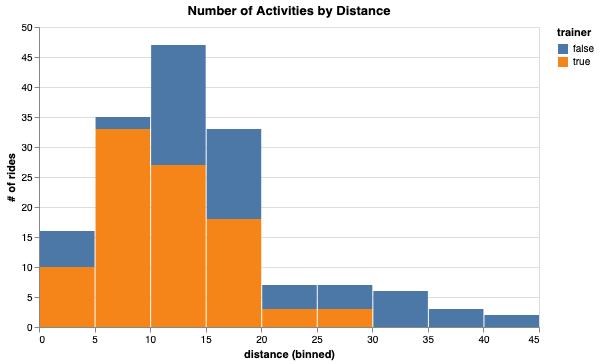

In [16]:
alt.Chart(rides).mark_bar().encode(
    alt.X("distance:Q", bin=True),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
    color='trainer:N',
).properties(
    width=500,
    title='Number of Activities by Distance'
)

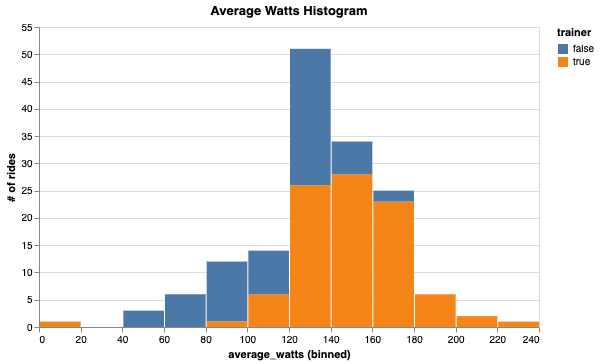

In [17]:
alt.Chart(rides).mark_bar().encode(
    alt.X("average_watts:Q",bin=alt.Bin(step=20)),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
    color='trainer:N',
).properties(
    width=500,
    title='Average Watts Histogram'
)

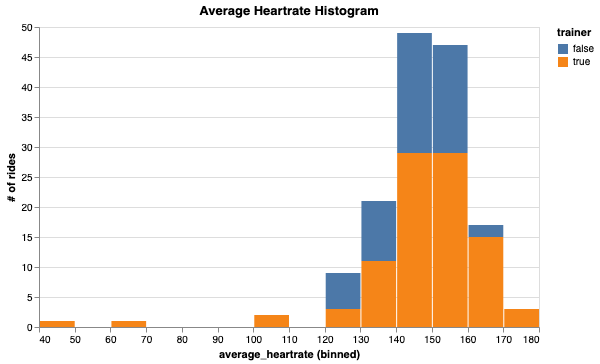

In [18]:
alt.Chart(rides).mark_bar().encode(
    alt.X("average_heartrate:Q",bin=alt.Bin(step=10)),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
    color='trainer:N',
).properties(
    width=500,
    title='Average Heartrate Histogram'
)

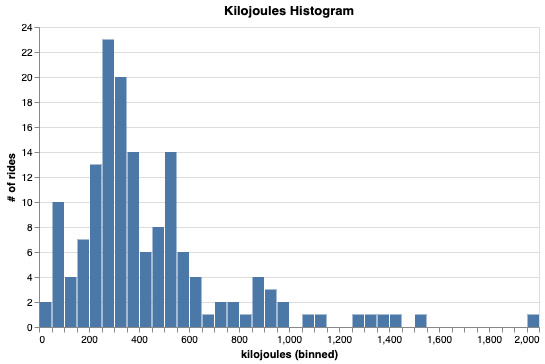

In [19]:
alt.Chart(rides).mark_bar().encode(
    alt.X("kilojoules:Q",bin=alt.Bin(step=50)),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
).properties(
    width=500,
    title='Kilojoules Histogram'
)

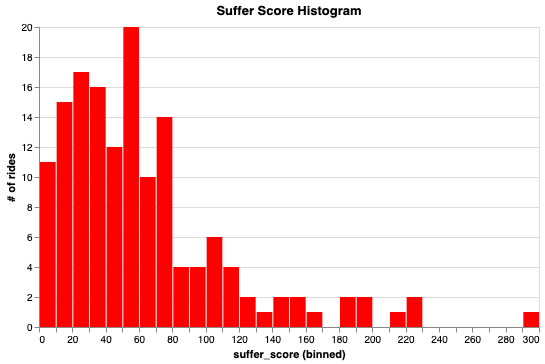

In [20]:
alt.Chart(rides).mark_bar(color='red').encode(
    alt.X("suffer_score:Q",bin=alt.Bin(step=10)),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
).properties(
    width=500,
    title='Suffer Score Histogram'
)

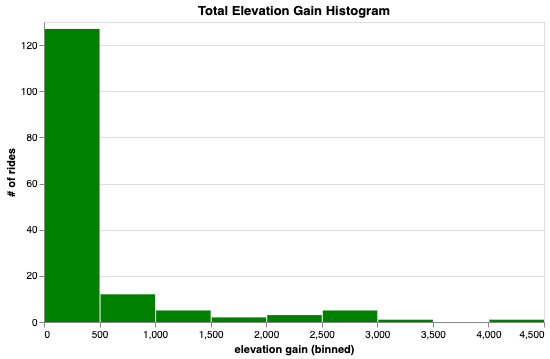

In [21]:
alt.Chart(rides).mark_bar(color='green').encode(
    alt.X("elevation gain:Q",bin=alt.Bin(step=500)),
    y=alt.Y('count(activity_id):Q', axis=alt.Axis(title='# of rides')),
).properties(
    width=500,
    title='Total Elevation Gain Histogram'
)

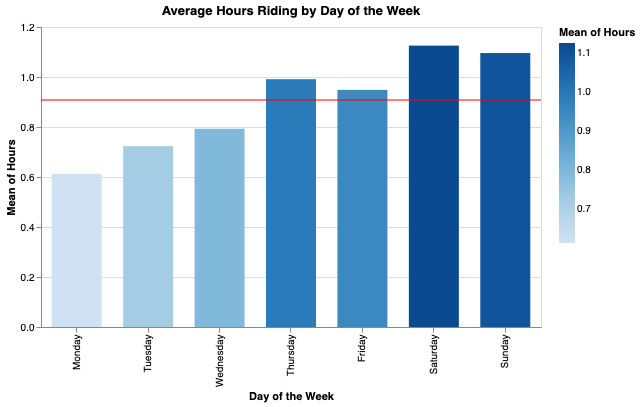

In [22]:
categoryNames = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

bar = alt.Chart(rides).mark_bar(size=50).encode(
    x=alt.X('dow', sort=categoryNames, axis=alt.Axis(title='Day of the Week')),
    y='mean(Hours)',
    color='mean(Hours):Q'
)

rule = alt.Chart(rides).mark_rule(color='red').encode(
    y='mean(Hours):Q'
)

(bar + rule).properties(
    width=500,
    title='Average Hours Riding by Day of the Week'
)

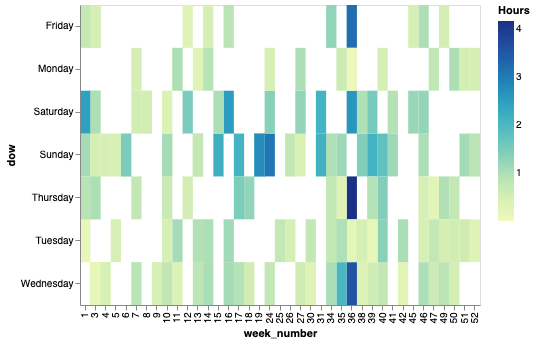

In [23]:
alt.Chart(rides).mark_rect().encode(
    x='week_number:O',
    y='dow:O',
    color='Hours:Q'
)

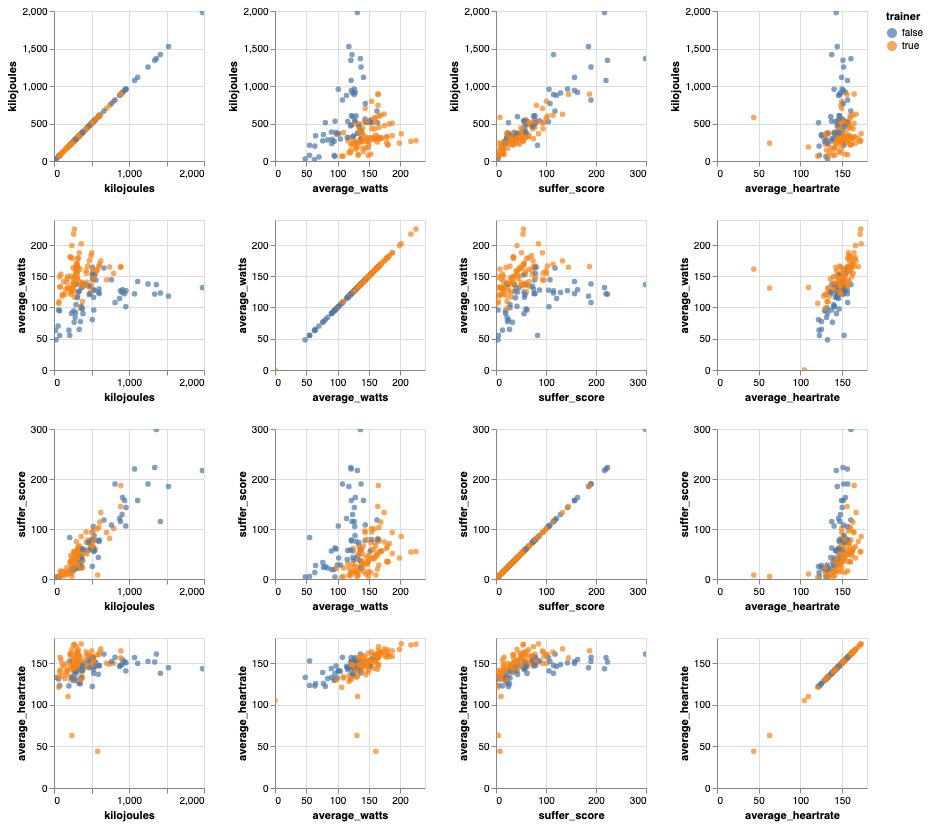

In [24]:
alt.Chart(rides).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='trainer:N',
).properties(
    width=150,
    height=150
).repeat(
    row=['kilojoules', 'average_watts', 'suffer_score','average_heartrate'],
    column=['kilojoules', 'average_watts', 'suffer_score','average_heartrate']
).interactive()

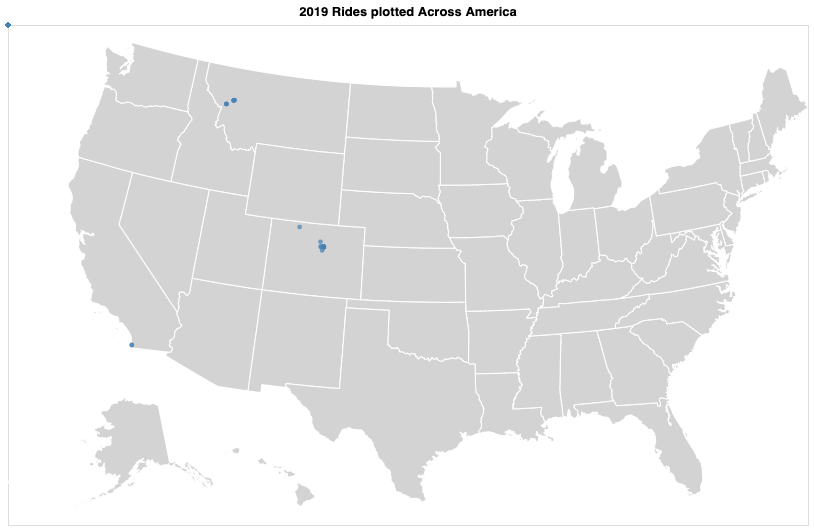

In [25]:
states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('albersUsa')

# airport positions on background
points = alt.Chart(rides).mark_circle(
    size=20,
    color='steelblue'
).encode(
    longitude='start_longitude:Q',
    latitude='start_latitude:Q',
    tooltip=['name', 'date', 'distance', 'elevation gain']
)

background + points.properties(
    title='2019 Rides plotted Across America'
)

## Yearly Summary

In [26]:
# Set Year and Workout Type:
target_year = 2019
# Examples: 'Ride', 'Run', 'Walk', 'Swim', 'WeightTraining', 'Hike'
target_type = 'Ride'

In [27]:
def yearly_summary(year, workout_type):    
    # Data Setup
    year_data = rides[(rides['year'] == year) & (rides.type == workout_type)].copy()
    year_data["moving_time2"] = year_data["moving_time"].astype(str) 
    year_data["date"] = year_data["date"].astype(str) 
      
    print('====== {} {} Summary ====== '.format(year, workout_type))
    print('Total Number of {} Workouts: {:,}'.format(workout_type, len(year_data)))
    print('Total {} Distance: {:,} miles'.format(workout_type, round(year_data['distance'].sum(),2)))
    print('Total {} Elevation Gain: {:,} feet'.format(workout_type, round(year_data['elevation gain'].sum(),2)))
    print(' ') 
    
    average_cycling_distance = round(year_data['distance'].mean(),1)
    print('Average {} Distance: {:,} miles'.format(workout_type, average_cycling_distance))
    average_cycling_time = round(year_data['moving_time'].mean(),2)
    print('Average {} Time: {:,} minutes'.format(workout_type, average_cycling_time))
    average_cycling_speed = round(year_data['average_speed'].mean(), 2)
    print('Average {} Speed: {:,} mph'.format(workout_type, average_cycling_speed))
    average_cycling_hr = int(round(year_data['average_heartrate'].mean(), 2))
    print('Average {} Heartrate: {:,} bpm'.format(workout_type, average_cycling_hr))
    average_cycling_ascent = int(round(year_data['elevation gain'].mean(), 2))
    print('Average {} Total Ascent: {:,} ft'.format(workout_type, average_cycling_ascent))
    average_cycling_power = int(round(year_data['average_watts'].mean(), 2))
    print('Average {} Power: {:,} watts'.format(workout_type, average_cycling_power))
    print(' ')
   
    print('{}s with the highest power:'.format(workout_type))
    for index, row in year_data.sort_values(by=['average_watts'], ascending=False).head(5).iterrows():
        print(str(row["average_watts"]) + " watts " + "for " + row["moving_time2"] + " minutes: " + "'"+ row["name"] + "'" + " on " + row["date"] ) 
    print(' ')
    
    print('Longest {}s:'.format(workout_type))
    for index, row in year_data.sort_values(by=['distance'], ascending=False).head(5).iterrows():
        print(str(row["distance"]) + " mi: " + row["name"] + " on " + row["date"] )   

In [28]:
yearly_summary(year=target_year, workout_type=target_type)

====== 2019 Ride Summary ====== 
Total Number of Ride Workouts: 156
Total Ride Distance: 2,211.89 miles
Total Ride Elevation Gain: 53,716.21 feet
 
Average Ride Distance: 14.2 miles
Average Ride Time: 54.47 minutes
Average Ride Speed: 16.64 mph
Average Ride Heartrate: 146 bpm
Average Ride Total Ascent: 344 ft
Average Ride Power: 134 watts
 
Rides with the highest power:
225.5 watts for 20.05 minutes: 'FTP Test' on 2019-12-31
217.4 watts for 19.983333333333334 minutes: '20 min FTP Test Ride with Matt Wilpers' on 2019-09-24
202.0 watts for 29.966666666666665 minutes: '30 min Tabata Ride with Robin Arzon' on 2019-02-27
199.1 watts for 19.983333333333334 minutes: '20 min FTP Test Ride with Matt Wilpers' on 2019-01-16
187.6 watts for 29.966666666666665 minutes: '30 min Pop Ride with Cody Rigsby' on 2019-06-25
 
Longest Rides:
41.96 mi: TCH Gravel Camp 2019: Seeley to Ovando Abonded on 2019-09-04
41.94 mi: Red Rocks and Back. Slow & steady gets it done.  on 2019-06-16
39.46 mi: TCH Gravel Ca